In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 30,5
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import import_ipynb
from nbeats_keras.model import NBeatsNet
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import LevelsCreater as lc

importing Jupyter notebook from LevelsCreater.ipynb


In [4]:
a='Data'
b='sales_train_validation.csv'
sale=pd.read_csv(os.path.join(a,b))

In [5]:
levels = lc.LevelsCreater()
level5 = levels.level_5(sale)

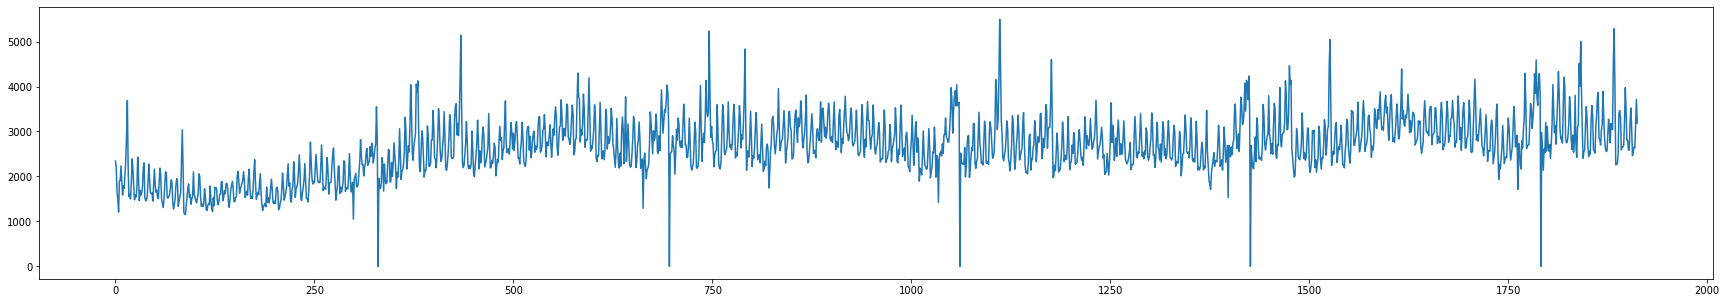

In [6]:
ts1 = level5.iloc[0,1:]
plt.plot(list(range(0,level5.iloc[0,:].shape[0])),level5.iloc[0,:]) 
plt.show()


In [7]:
def normalize(df):
    df = (df-df.mean())/df.std()
    return df

In [8]:
ts = normalize(ts1)
lag=28
y = ts.iloc[lag:ts.shape[0]]
X = ts.iloc[0:y.shape[0]].values.reshape(-1,1)
t = np.arange(lag,ts.shape[0])
lm = LinearRegression()
y = y.values.reshape(-1,1)

In [9]:
timeseries = pd.DataFrame(list(zip(X,t)))
sinx = np.sin(2*np.pi*t/lag)
cosx = np.cos(2*np.pi*t/lag)
p= pd.DataFrame(list(zip(sinx,cosx)))
X_predictors = pd.concat([timeseries,p],axis=1)

In [10]:
lm.fit(X_predictors,y)
err = (lm.predict(X_predictors)-y)
y_pred = lm.predict(X_predictors)

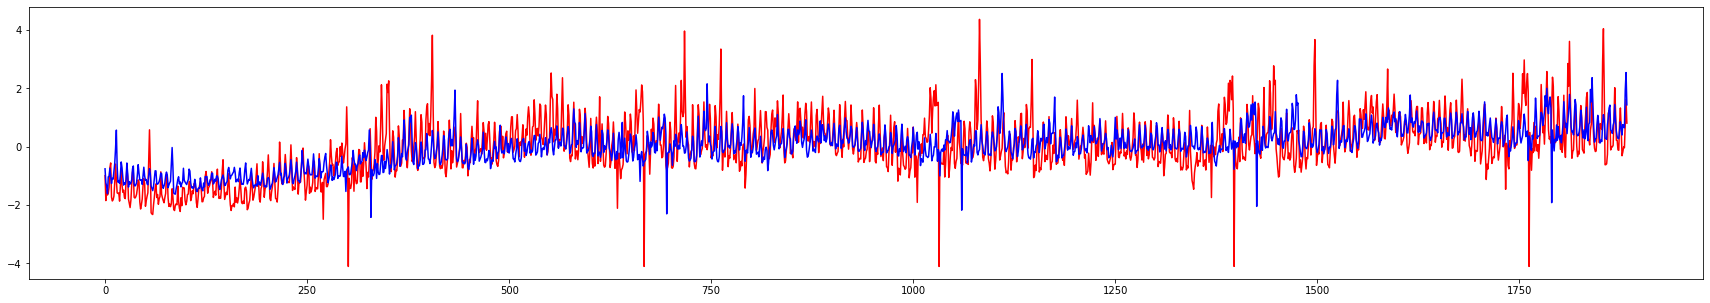

In [11]:
plt.plot(y,color='r')
plt.plot(y_pred,color='b')
plt.show()

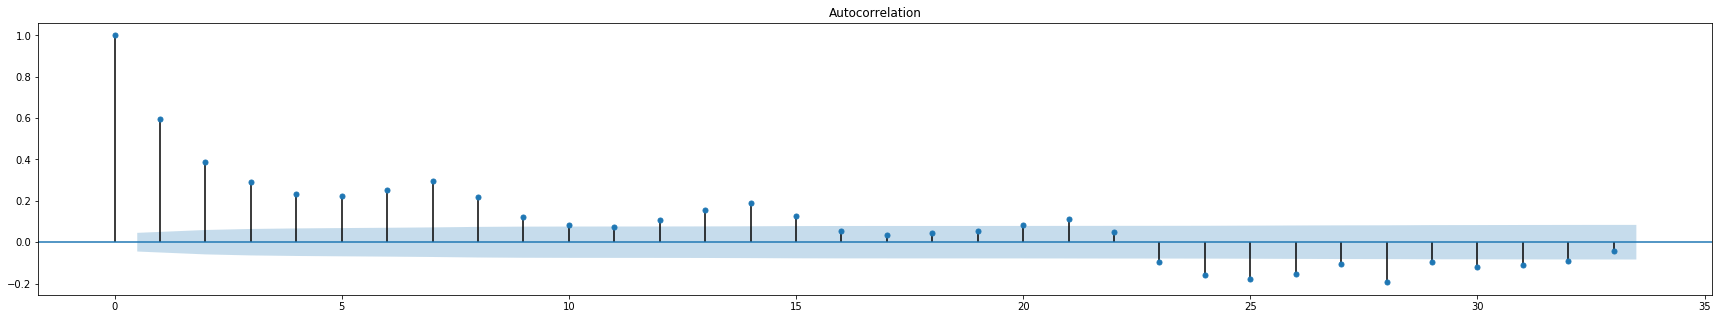

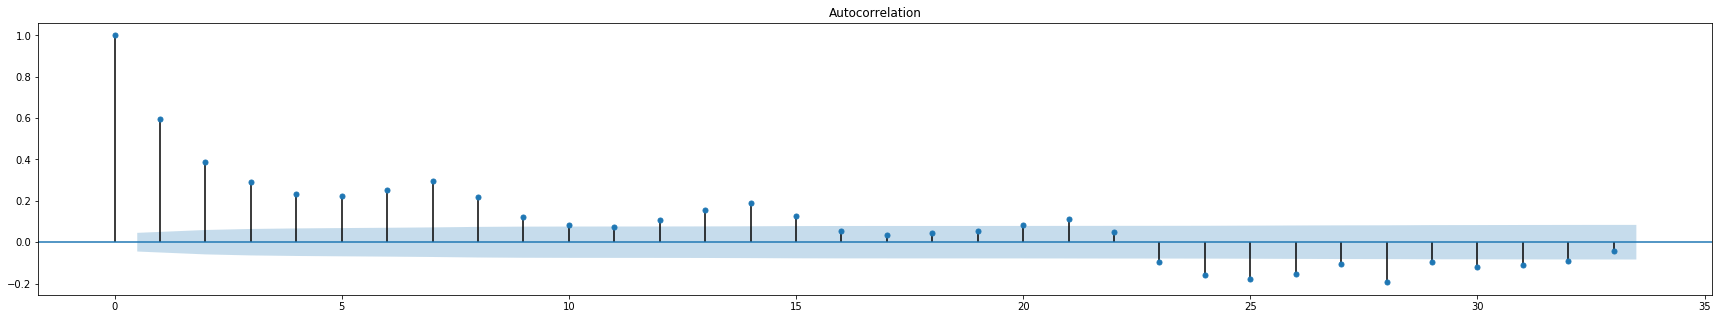

In [12]:
mse = np.mean(np.square(err))
plot_acf(err)

In [13]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [14]:
level1 = levels.level_1(sale)

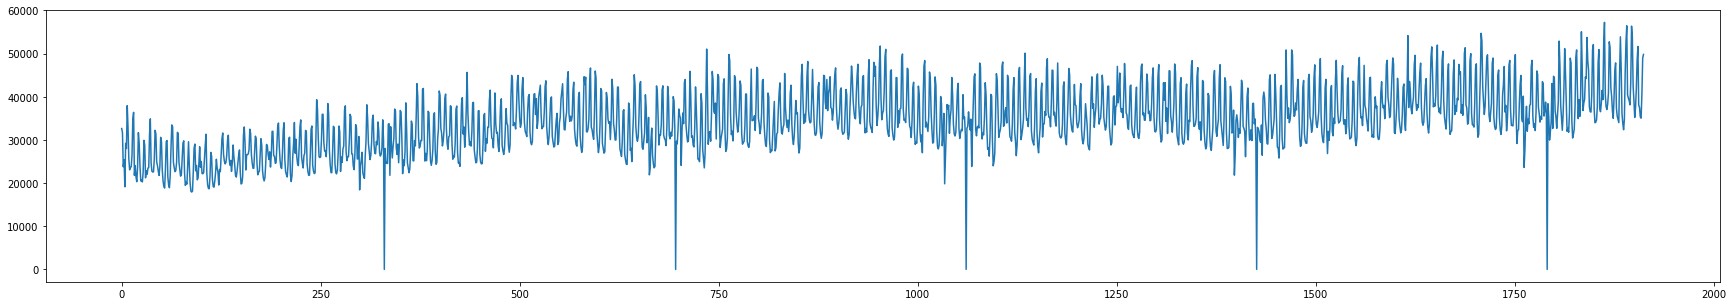

In [15]:
plt.plot(np.arange(level1.shape[1]),level1.iloc[0])
plt.show()

In [16]:
level5
x = np.random.uniform(size=(50000, 10, 1))
y = np.mean(x, axis=1, keepdims=True)
q=level5.iloc[0,:]
q = pd.DataFrame(q)
q

,FOODS_1
d_1,2343
d_2,2216
d_3,1657
d_4,1508
d_5,1209
...,...
d_1909,2657
d_1910,2639
d_1911,3169
d_1912,3712


In [17]:

from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols=pd.DataFrame()
    names=list()
    for i in range(n_in, 0, -1):
        df=pd.DataFrame()
        names=list()
        df=data.shift(i)
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
        df.columns=names
        cols = pd.concat([cols, df], axis=1, sort=False)
    for i in range(0, n_out):
        df=pd.DataFrame()
        names=list()
        df=data.shift(-i)
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
            
        df.columns=names
        cols=pd.concat([cols,df],axis=1,sort=False)
    if dropnan:
        cols.dropna(inplace=True)
    return cols


x = series_to_supervised(q,10,1)
y= x.iloc[:,10]
x = x.iloc[:,0:10]
x = np.array(x).reshape(1903,10,-1)

y = np.array(y).reshape(1903,-1,1)

In [18]:

# https://keras.io/layers/recurrent/
num_samples, time_steps, input_dim, output_dim = 1903, 10, 1, 1

# Definition of the model.
model = NBeatsNet(backcast_length=time_steps, forecast_length=output_dim,
                  stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK), nb_blocks_per_stack=2,
                  thetas_dim=(4, 4), share_weights_in_stack=True, hidden_layer_units=64)

# Definition of the objective function and the optimizer.
model.compile_model(loss='mae', learning_rate=1e-4)

# Definition of the data. The problem to solve is to find f such as | f(x) - y | -> 0.
#x = np.random.uniform(size=(num_samples, time_steps, input_dim))
#y = np.mean(x, axis=1, keepdims=True)

# Split data into training and testing datasets.
c = num_samples // 10
x_train, y_train, x_test, y_test = x[c:], y[c:], x[:c], y[:c]

# Train the model.
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=1903)

# Save the model for later.
model.save('n_beats_model.h5')

# Predict on the testing set.
predictions = model.predict(x_test)
print(predictions.shape)

# Load the model.
model2 = NBeatsNet.load('n_beats_model.h5')

predictions2 = model2.predict(x_test)
np.testing.assert_almost_equal(predictions, predictions2)




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_variable (InputLayer)     (None, 10, 1)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 10)           0           input_variable[0][0]             
__________________________________________________________________________________________________
0/0/generic/d1 (Dense)          (None, 64)           704         lambda_1[0][0]                   
                                                                 subtract_1[0][0]                 
__________________________________________________________________________________________________
0/0/generic/d2 (Dense)          (None, 64)           4160        0/0/generic/d1[0][0]       

Epoch 8/15
1713/1713 [==============================] - 0s 14us/step - loss: 2442.4429 - val_loss: 1410.9353
Epoch 9/15
1713/1713 [==============================] - 0s 16us/step - loss: 2318.0840 - val_loss: 1333.7140
Epoch 10/15
1713/1713 [==============================] - 0s 16us/step - loss: 2193.6912 - val_loss: 1256.4620
Epoch 11/15
1713/1713 [==============================] - 0s 17us/step - loss: 2069.4087 - val_loss: 1179.4127
Epoch 12/15
1713/1713 [==============================] - 0s 20us/step - loss: 1945.5144 - val_loss: 1102.8372
Epoch 13/15
1713/1713 [==============================] - 0s 22us/step - loss: 1822.4904 - val_loss: 1026.6213
Epoch 14/15
1713/1713 [==============================] - 0s 30us/step - loss: 1700.0979 - val_loss: 951.2628
Epoch 15/15
1713/1713 [==============================] - 0s 22us/step - loss: 1579.1637 - val_loss: 876.8471
(190, 1, 1)


In [19]:
x = np.array(x).reshape(1903,10,-1)

y = np.array(y).reshape(1903,-1,1)
x.shape



(1903, 10, 1)

In [20]:
x = np.random.uniform(size=(num_samples, time_steps, input_dim))
y = np.mean(x, axis=1, keepdims=True)
x.shape


x.shape

(1903, 10, 1)

In [21]:
c=5000
x_train, y_train, x_test, y_test = x[c:], y[c:], x[:c], y[:c]
x_train.shape

(0, 10, 1)

In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
model = ARIMA(q.iloc[:,0], order=(28,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = DataFrame(model_fit.resid)
#residuals.plot(kind='kde')
predictions=model_fit.forecast()

predictions

#print(mean_absolute_percentage_error(predictions,y_test[:,0,0]))

c:\users\chaitanya\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\chaitanya\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
